# Pronostico recuperados acumulados y diarios en Colombia de COVID-19

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
from keras.models import load_model

In [3]:
colombia = pd.read_csv('colombia.csv')
colombia

,fecha reporte web,ID de caso,Casos acumulados,Recuperados,Recuperados acumulados,Fallecidos,Fallecidos acumulados
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,2,3,2,3,0,0
4,2020-03-10,0,3,0,3,0,0
...,...,...,...,...,...,...,...
727,2022-03-03,1051,6068074,556,5899871,11,138792
728,2022-03-04,1351,6069425,780,5900651,23,138815
729,2022-03-05,1191,6070616,506,5901157,7,138822
730,2022-03-06,1088,6071704,574,5901731,3,138825


In [4]:

colombia.set_index('fecha reporte web', inplace = True)
colombia_rep = colombia.drop(['Recuperados acumulados', 'ID de caso', 'Recuperados acumulados','Fallecidos','Fallecidos acumulados','Casos acumulados'],axis=1)
colombia_rep

,Recuperados
fecha reporte web,
2020-03-06,1
2020-03-07,0
2020-03-08,0
2020-03-09,2
2020-03-10,0
...,...
2022-03-03,556
2022-03-04,780
2022-03-05,506


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(colombia_rep)
col_scaled_rep = scaler.transform(colombia_rep)

In [6]:
n_train_data = 670
n_test_data = 60

train_scaled_col_rep = col_scaled_rep[:n_train_data]
train_scaled_col_rep

test_scaled_col_rep = col_scaled_rep[n_train_data:n_train_data+n_test_data]
test_scaled_col_rep

array([[0.46047611],
       [0.65137536],
       [0.74095905],
       [0.88253887],
       [0.8660516 ],
       [0.76718492],
       [0.6520303 ],
       [0.84028134],
       [0.85150065],
       [0.98117774],
       [1.        ],
       [0.9077681 ],
       [0.68135999],
       [0.80628168],
       [0.77344951],
       [0.85127285],
       [0.86579532],
       [0.78221994],
       [0.72771798],
       [0.5939689 ],
       [0.5400934 ],
       [0.49692465],
       [0.48636027],
       [0.5822655 ],
       [0.51221596],
       [0.4462384 ],
       [0.42604932],
       [0.3994248 ],
       [0.41739279],
       [0.37596105],
       [0.37069309],
       [0.34927957],
       [0.28569395],
       [0.25169429],
       [0.26849479],
       [0.24192722],
       [0.22589555],
       [0.14773051],
       [0.18161627],
       [0.15311236],
       [0.08778974],
       [0.10179965],
       [0.1134461 ],
       [0.10900393],
       [0.11085483],
       [0.12477932],
       [0.09328549],
       [0.078

In [7]:
from keras.preprocessing.sequence import TimeseriesGenerator

window_size= 60
n_features= 1
batch_size = 1

train_generator_col = TimeseriesGenerator(train_scaled_col_rep, train_scaled_col_rep, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(train_scaled_col_rep))
print("Total number of samples in the generated data of Colombia = ", len(train_generator_col))

test_generator_col = TimeseriesGenerator(test_scaled_col_rep , test_scaled_col_rep , length=len(test_scaled_col_rep )-1 ,batch_size=batch_size)
print("Total number of samples in the original training data of Colombia = ", len(test_scaled_col_rep ))
print("Total number of sambles in the generated data of Colombia", len(test_generator_col))

Total number of samples in the original training data of Colombia =  670
Total number of samples in the generated data of Colombia =  610
Total number of samples in the original training data of Colombia =  60
Total number of sambles in the generated data of Colombia 1


## Red neuronal simple

In [8]:
def model_rnn_builder(hp):
  model_rnn_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_rnn_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_rnn_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_rnn_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_rnn_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_rnn_col

In [9]:
tuner = kt.BayesianOptimization(model_rnn_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_rnn',
                     project_name='hp_rnn_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 03m 43s]
val_loss: 0.001227363827638328

Best val_loss So Far: 0.0002076067466987297
Total elapsed time: 01h 04m 26s
INFO:tensorflow:Oracle triggered exit


In [10]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 224 y el learning rate mas optimo será de 0.0001.



In [11]:
model_rnn_col = tuner.hypermodel.build(best_hps)
history_rnn_col = model_rnn_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 72s 113ms/step - loss: 0.0268 - root_mean_squared_error: 0.1036 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0361 - lr: 1.0000e-04
Epoch 2/100
610/610 [==============================] - 67s 110ms/step - loss: 0.0084 - root_mean_squared_error: 0.0621 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0512 - lr: 1.0000e-04
Epoch 3/100
610/610 [==============================] - 67s 110ms/step - loss: 0.0067 - root_mean_squared_error: 0.0599 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0294 - lr: 1.0000e-04
Epoch 4/100
610/610 [==============================] - 67s 110ms/step - loss: 0.0059 - root_mean_squared_error: 0.0582 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0022 - lr: 1.0000e-04
Epoch 5/100
610/610 [==============================] - 66s 109ms/step - loss: 0.0055 - root_mean_squared_error: 0.0578 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0150 - lr: 1.0000e-04
Epoch 6/100
610/610 [==============

In [12]:
model_rnn_col.save("model_rnn.h5")

Best epoch: 2


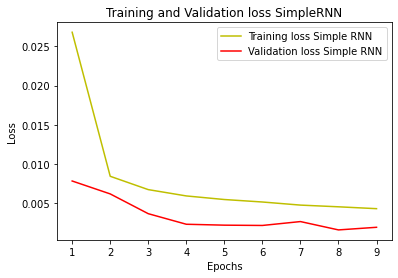

In [13]:
val_acc_per_epoch = history_rnn_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_rnn_col = history_rnn_col.history['loss']
val_loss_rnn_col = history_rnn_col.history['val_loss']
epochs = range(1,len(loss_rnn_col)+1)

plt.plot(epochs, loss_rnn_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_rnn_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
model_rnn_col = load_model('model_rnn.h5')

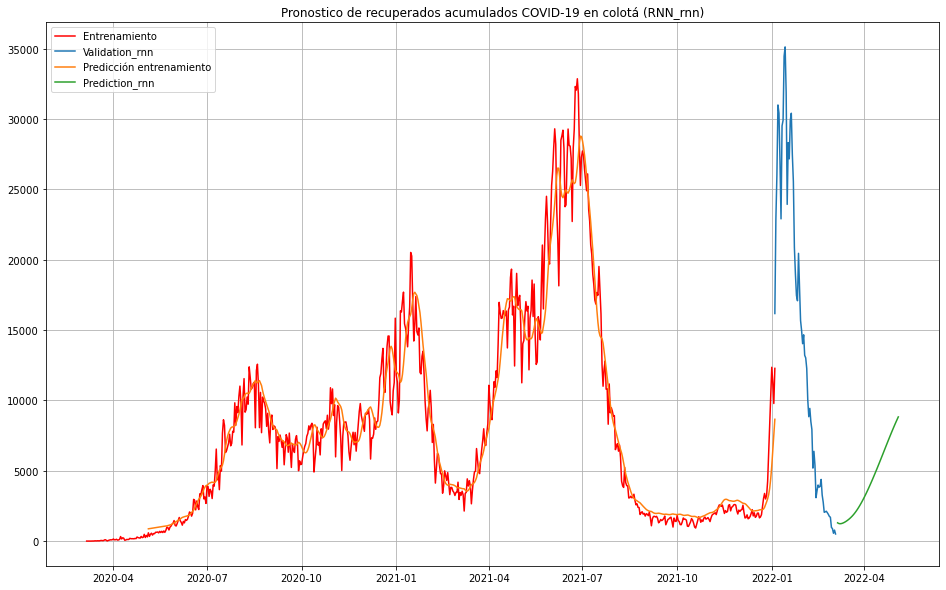

In [15]:
predictions_rnn_col = []

first_batch = test_scaled_col_rep[-window_size:]
current_batch_rnn_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_rnn_col = model_rnn_col.predict(current_batch_rnn_col)[0]
    

    predictions_rnn_col.append(current_pred_rnn_col)
    
    
    current_batch_rmv_first_rnn_col= current_batch_rnn_col[:,1:,:]
 

    current_batch_rnn_col= np.append(current_batch_rmv_first_rnn_col,[[current_pred_rnn_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_rep)
dates_train_data_rnn_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_rnn_col = pd.DataFrame({'Date':dates_train_data_rnn_col,'train':train_data_actual_scale[:,0]})
df_train_rnn_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_rnn_col = model_rnn_col.predict(train_generator_col)
train_prediction_data_actual_scale_rnn_col =scaler.inverse_transform(train_prediction_rnn_col)
dates_predict_train_data_rnn_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_rnn_col = pd.DataFrame({'Date':dates_predict_train_data_rnn_col,'train':train_prediction_data_actual_scale_rnn_col[:,0]})
df_predict_train_rnn_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_rnn_col = scaler.inverse_transform(test_scaled_col_rep)
dates_test_data_rnn_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_rnn_col = pd.DataFrame({'Date':dates_test_data_rnn_col,'Test_rnn_col':test_data_actual_scale_rnn_col[:,0]})
df_test_rnn_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_rnn_col = scaler.inverse_transform(predictions_rnn_col)
dates_predictions_rnn_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_rnn_col  = pd.DataFrame({'Date':dates_predictions_rnn_col,'Predictions_rnn_col':predictions_actual_scale_rnn_col[:,0]})
df_predictions_rnn_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col,'r', label='Entrenamiento')
plt.plot(df_test_rnn_col['Test_rnn_col'], label='Validation_rnn')
plt.plot(df_predict_train_rnn_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN_rnn)')
plt.plot(df_predictions_rnn_col ['Predictions_rnn_col'], label='Prediction_rnn')
plt.grid()
plt.legend()

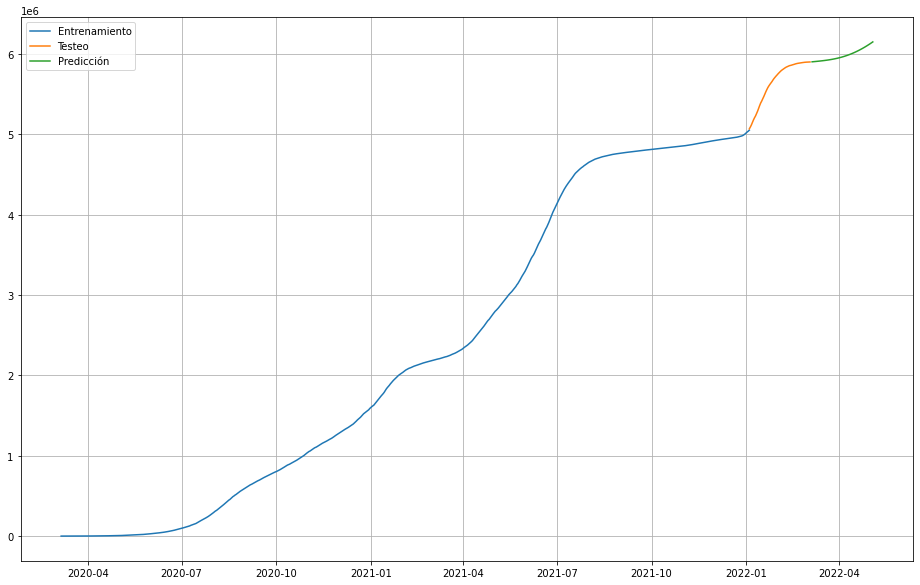

In [16]:
# Creación columna con casos acumulados.
df_predictions_rnn_col['acumulados']= df_predictions_rnn_col['Predictions_rnn_col'].cumsum()
df_predictions_rnn_col['acumulados'] = [i+colombia['Recuperados acumulados'].max() for i in df_predictions_rnn_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_rnn_col['acumulados']=df_train_rnn_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_rnn_col['acumulados']=df_test_rnn_col['Test_rnn_col'].cumsum()
df_test_rnn_col['acumulados'] = [i+df_train_rnn_col['acumulados'].max() for i in df_test_rnn_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_rnn_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_rnn_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_rnn_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [17]:
df_predictions_rnn_col

,Predictions_rnn_col,acumulados
Date,,
2022-03-06,1297.627356,5.903029e+06
2022-03-07,1254.643316,5.904283e+06
2022-03-08,1236.547637,5.905520e+06
2022-03-09,1237.102596,5.906757e+06
2022-03-10,1251.574953,5.908008e+06
2022-03-11,1276.385473,5.909285e+06
2022-03-12,1309.157595,5.910594e+06
2022-03-13,1348.267521,5.911942e+06
2022-03-14,1392.871695,5.913335e+06


## Red neuronal con celdas LSTM

In [8]:
def model_lstm_builder(hp):
  model_lstm_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=50, max_value=400, step=50)
  model_lstm_col.add(LSTM(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='relu', input_shape=(window_size, n_features),return_sequences=True))
  model_lstm_col.add(LSTM(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='relu'))
  model_lstm_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_lstm_col.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_lstm_col

In [9]:
tuner = kt.BayesianOptimization(model_lstm_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_lstm',
                     project_name='hp_lstm_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 02m 29s]
val_loss: 0.008362160995602608

Best val_loss So Far: 0.008362160995602608
Total elapsed time: 00h 20m 07s
INFO:tensorflow:Oracle triggered exit


In [10]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 50 y el learning rate mas optimo será de 0.0001.



In [28]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 10),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

In [29]:
model_lstm_col = tuner.hypermodel.build(best_hps)
history_lstm_col = model_lstm_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)


Epoch 1/100
610/610 [==============================] - 39s 57ms/step - loss: 0.0968 - root_mean_squared_error: 0.3096 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - 34s 56ms/step - loss: 0.0077 - root_mean_squared_error: 0.0847 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0618 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - 34s 56ms/step - loss: 0.0029 - root_mean_squared_error: 0.0494 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0299 - lr: 0.0010
Epoch 4/100
610/610 [==============================] - 34s 56ms/step - loss: 0.0033 - root_mean_squared_error: 0.0537 - val_loss: 6.7867e-04 - val_root_mean_squared_error: 0.0108 - lr: 0.0010
Epoch 5/100
610/610 [==============================] - 34s 55ms/step - loss: 0.0028 - root_mean_squared_error: 0.0489 - val_loss: 5.2563e-04 - val_root_mean_squared_error: 0.0098 - lr: 0.0010
Epoch 6/100
610/610 [==============================]

In [30]:
model_lstm_col.save("model_lstm.h5")

Best epoch: 1


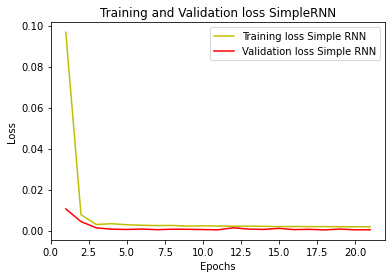

In [31]:
val_acc_per_epoch = history_lstm_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_lstm_col = history_lstm_col.history['loss']
val_loss_lstm_col = history_lstm_col.history['val_loss']
epochs = range(1,len(loss_lstm_col)+1)

plt.plot(epochs, loss_lstm_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_lstm_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
model_lstm_col = load_model('model_lstm.h5')

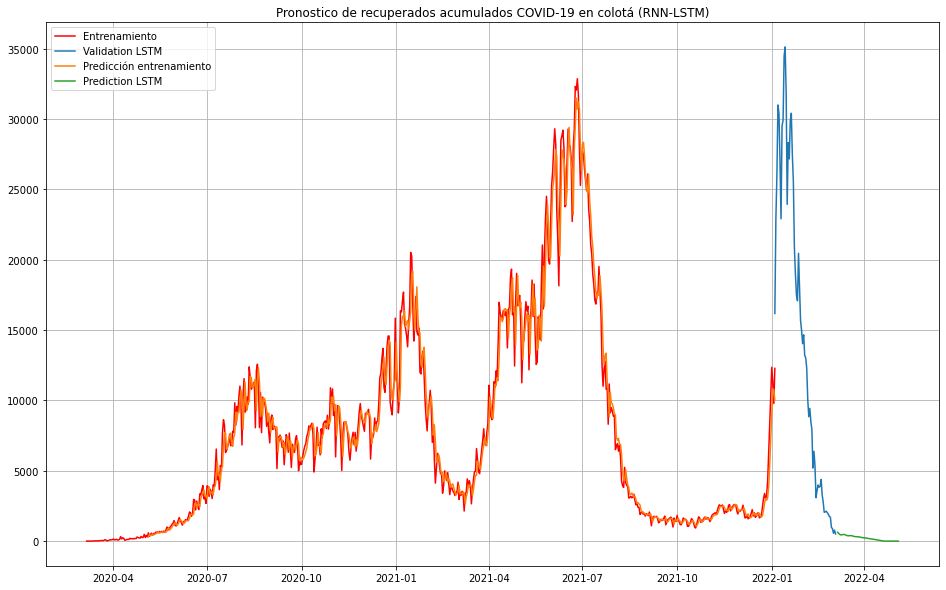

In [33]:
predictions_lstm_col = []

first_batch = test_scaled_col_rep[-window_size:]
current_batch_lstm_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_lstm_col = model_lstm_col.predict(current_batch_lstm_col)[0]
    

    predictions_lstm_col.append(current_pred_lstm_col)
    
    
    current_batch_rmv_first_lstm_col= current_batch_lstm_col[:,1:,:]
 

    current_batch_lstm_col= np.append(current_batch_rmv_first_lstm_col,[[current_pred_lstm_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_rep)
dates_train_data_lstm_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_lstm_col = pd.DataFrame({'Date':dates_train_data_lstm_col,'train':train_data_actual_scale[:,0]})
df_train_lstm_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_lstm_col = model_lstm_col.predict(train_generator_col)
train_prediction_data_actual_scale_lstm_col =scaler.inverse_transform(train_prediction_lstm_col)
dates_predict_train_data_lstm_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_lstm_col = pd.DataFrame({'Date':dates_predict_train_data_lstm_col,'train':train_prediction_data_actual_scale_lstm_col[:,0]})
df_predict_train_lstm_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_lstm_col = scaler.inverse_transform(test_scaled_col_rep)
dates_test_data_lstm_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_lstm_col = pd.DataFrame({'Date':dates_test_data_lstm_col,'Test_LSTM_col':test_data_actual_scale_lstm_col[:,0]})
df_test_lstm_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_lstm_col = scaler.inverse_transform(predictions_lstm_col)
dates_predictions_lstm_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_lstm_col  = pd.DataFrame({'Date':dates_predictions_lstm_col,'Predictions_LSTM_col':predictions_actual_scale_lstm_col[:,0]})
df_predictions_lstm_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col,'r', label='Entrenamiento')
plt.plot(df_test_lstm_col['Test_LSTM_col'], label='Validation LSTM')
plt.plot(df_predict_train_lstm_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-LSTM)')
plt.plot(df_predictions_lstm_col ['Predictions_LSTM_col'], label='Prediction LSTM')
plt.grid()
plt.legend()

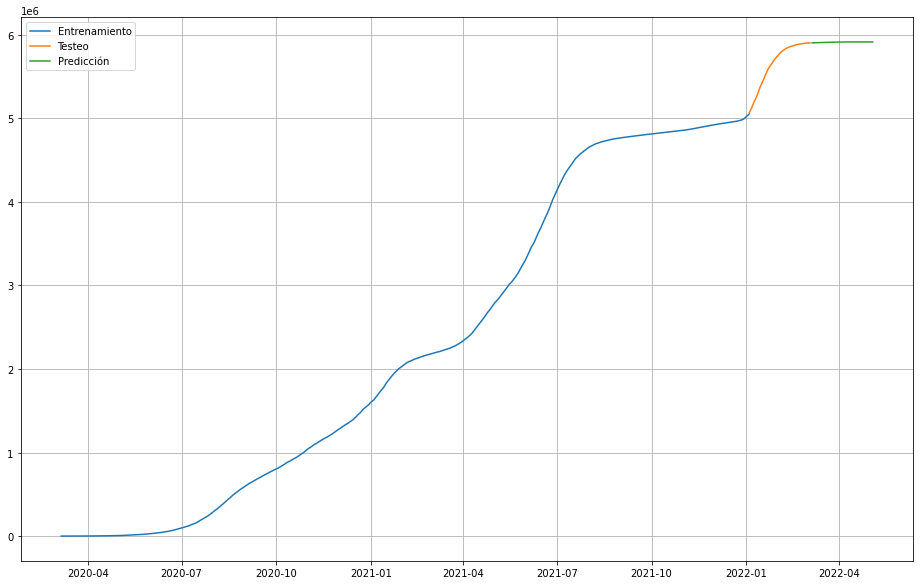

In [34]:
# Creación columna con casos acumulados.
df_predictions_lstm_col['acumulados']= df_predictions_lstm_col['Predictions_LSTM_col'].cumsum()
df_predictions_lstm_col['acumulados'] = [i+colombia['Recuperados acumulados'].max() for i in df_predictions_lstm_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_lstm_col['acumulados']=df_train_lstm_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_lstm_col['acumulados']=df_test_lstm_col['Test_LSTM_col'].cumsum()
df_test_lstm_col['acumulados'] = [i+df_train_lstm_col['acumulados'].max() for i in df_test_lstm_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_lstm_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_lstm_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_lstm_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [35]:
df_predictions_lstm_col

,Predictions_LSTM_col,acumulados
Date,,
2022-03-06,628.006133,5.902359e+06
2022-03-07,550.725602,5.902910e+06
2022-03-08,480.966577,5.903391e+06
2022-03-09,443.224162,5.903834e+06
2022-03-10,443.648034,5.904278e+06
2022-03-11,462.544752,5.904740e+06
2022-03-12,472.562788,5.905213e+06
2022-03-13,459.053432,5.905672e+06
2022-03-14,427.585633,5.906099e+06


## Red neuronal con celdas GRU

In [18]:
def model_gru_builder(hp):
  model_gru_col = keras.Sequential()
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model_gru_col.add(GRU(units=hp_units,kernel_regularizer=regularizers.L2(0.0001),activation='tanh', input_shape=(window_size, n_features),return_sequences=True))
  model_gru_col.add(GRU(units=hp_units, kernel_regularizer=regularizers.L2(0.0001),activation='tanh'))
  model_gru_col.add(Dense(1, activation='relu'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_gru_col.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[RootMeanSquaredError()])
 #kernel_regularizer=regularizers.L2(0.001)
  return model_gru_col

In [19]:
tuner = kt.BayesianOptimization(model_gru_builder,
                     objective='val_loss',
                     max_trials=4,
                     seed=000,
                     directory='my_dir_gru',
                     project_name='hp_gru_col')


def sheduler(epoch, lr):
    if epoch < 5:
        return lr
    else: 
        return lr*tf.math.exp(-0.1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 5),
    tf.keras.callbacks.LearningRateScheduler(sheduler)
]

tuner.search(train_generator_col, validation_data=test_generator_col,epochs=100, callbacks=my_callbacks)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 4 Complete [00h 05m 06s]
val_loss: 0.0017377459444105625

Best val_loss So Far: 0.00029688613722100854
Total elapsed time: 00h 40m 54s
INFO:tensorflow:Oracle triggered exit


In [20]:
print(f"""
El número optimo de neuronas o unidades en ambas capas es de {best_hps.get('units')} y el learning rate mas optimo será de {best_hps.get('learning_rate')}.
""")


El número optimo de neuronas o unidades en ambas capas es de 96 y el learning rate mas optimo será de 0.001.



In [21]:
model_gru_col = tuner.hypermodel.build(best_hps)
history_gru_col = model_gru_col.fit(train_generator_col, epochs=100, validation_data=test_generator_col, callbacks=my_callbacks)

Epoch 1/100
610/610 [==============================] - 37s 53ms/step - loss: 0.0462 - root_mean_squared_error: 0.2124 - val_loss: 6.0707e-04 - val_root_mean_squared_error: 0.0144 - lr: 0.0010
Epoch 2/100
610/610 [==============================] - 32s 52ms/step - loss: 0.0036 - root_mean_squared_error: 0.0564 - val_loss: 6.0664e-04 - val_root_mean_squared_error: 0.0140 - lr: 0.0010
Epoch 3/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0028 - root_mean_squared_error: 0.0489 - val_loss: 7.1419e-04 - val_root_mean_squared_error: 0.0170 - lr: 0.0010
Epoch 4/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0028 - root_mean_squared_error: 0.0490 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0402 - lr: 0.0010
Epoch 5/100
610/610 [==============================] - 31s 51ms/step - loss: 0.0028 - root_mean_squared_error: 0.0496 - val_loss: 4.5421e-04 - val_root_mean_squared_error: 0.0108 - lr: 0.0010
Epoch 6/100
610/610 [=======================

In [22]:
model_gru_col.save("model_gru.h5")


Best epoch: 4


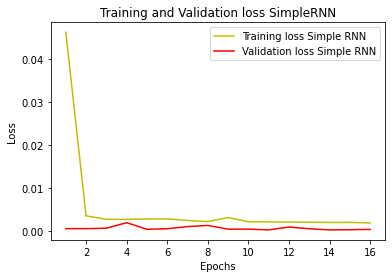

In [23]:
val_acc_per_epoch = history_gru_col.history['val_root_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

loss_gru_col = history_gru_col.history['loss']
val_loss_gru_col = history_gru_col.history['val_loss']
epochs = range(1,len(loss_gru_col)+1)

plt.plot(epochs, loss_gru_col, 'y',label='Training loss Simple RNN')
plt.plot(epochs, val_loss_gru_col, 'r',label='Validation loss Simple RNN')
plt.title('Training and Validation loss SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
model_gru_col = load_model('model_gru.h5')

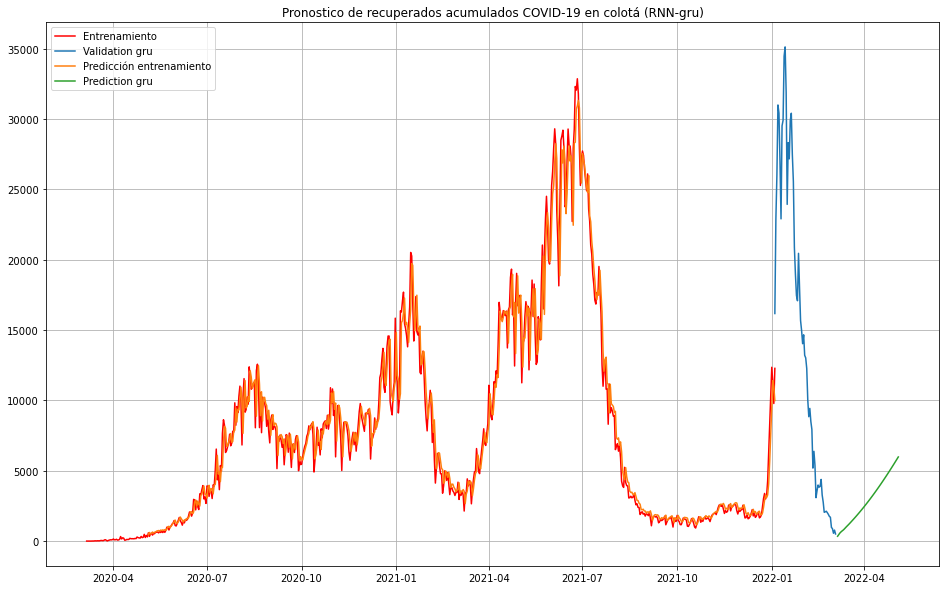

In [25]:
predictions_gru_col = []

first_batch = col_scaled_rep[-window_size:]
current_batch_gru_col = first_batch.reshape((1, window_size, n_features))

future = 60
for i in range(future):
    current_pred_gru_col = model_gru_col.predict(current_batch_gru_col)[0]
    

    predictions_gru_col.append(current_pred_gru_col)
    
    
    current_batch_rmv_first_gru_col= current_batch_gru_col[:,1:,:]
 

    current_batch_gru_col= np.append(current_batch_rmv_first_gru_col,[[current_pred_gru_col]], axis=1)


## Entrenamiento
train_data_actual_scale =scaler.inverse_transform(train_scaled_col_rep)
dates_train_data_gru_col = pd.date_range('2020-03-06', periods=n_train_data, freq='D')
df_train_gru_col = pd.DataFrame({'Date':dates_train_data_gru_col,'train':train_data_actual_scale[:,0]})
df_train_gru_col.set_index('Date', inplace = True)


## Predicción entrenamiento
train_prediction_gru_col = model_gru_col.predict(train_generator_col)
train_prediction_data_actual_scale_gru_col =scaler.inverse_transform(train_prediction_gru_col)
dates_predict_train_data_gru_col = pd.date_range('2020-05-05', periods=(n_train_data-window_size), freq='D')
df_predict_train_gru_col = pd.DataFrame({'Date':dates_predict_train_data_gru_col,'train':train_prediction_data_actual_scale_gru_col[:,0]})
df_predict_train_gru_col.set_index('Date', inplace = True)



## Testeo
test_data_actual_scale_gru_col = scaler.inverse_transform(test_scaled_col_rep)
dates_test_data_gru_col = pd.date_range('2022-01-04', periods=n_test_data, freq='D')
df_test_gru_col = pd.DataFrame({'Date':dates_test_data_gru_col,'Test_gru_col':test_data_actual_scale_gru_col[:,0]})
df_test_gru_col.set_index('Date', inplace = True)



## Predicción test


## Predicción
predictions_actual_scale_gru_col = scaler.inverse_transform(predictions_gru_col)
dates_predictions_gru_col  = pd.date_range('2022-03-06', periods=future, freq='D')
df_predictions_gru_col = pd.DataFrame({'Date':dates_predictions_gru_col,'Predictions_gru_col':predictions_actual_scale_gru_col[:,0]})
df_predictions_gru_col .set_index('Date', inplace = True)

#Grafica. 

plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col,'r', label='Entrenamiento')
plt.plot(df_test_gru_col['Test_gru_col'], label='Validation gru')
plt.plot(df_predict_train_gru_col['train'], label='Predicción entrenamiento')
plt.title('Pronostico de recuperados acumulados COVID-19 en colotá (RNN-gru)')
plt.plot(df_predictions_gru_col ['Predictions_gru_col'], label='Prediction gru')
plt.grid()
plt.legend()

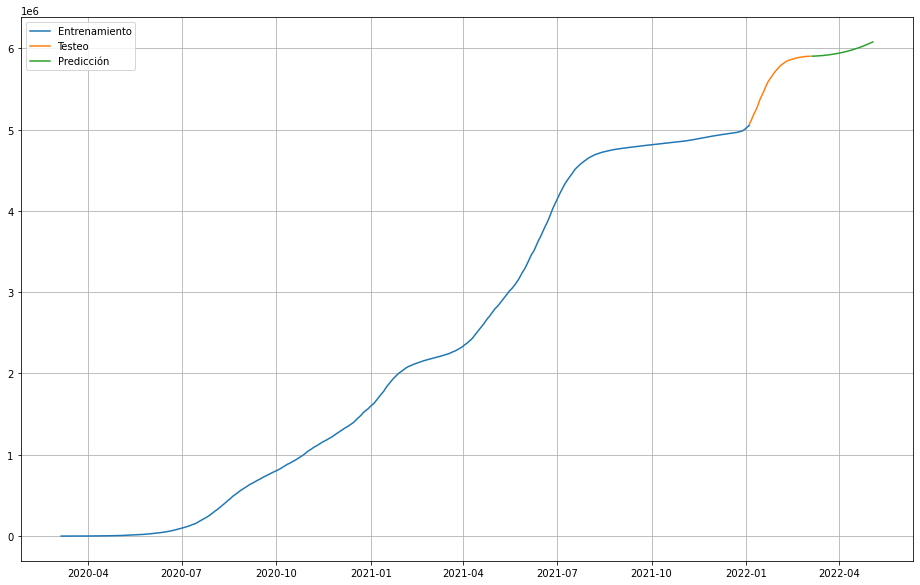

In [26]:
# Creación columna con casos acumulados.
df_predictions_gru_col['acumulados']= df_predictions_gru_col['Predictions_gru_col'].cumsum()
df_predictions_gru_col['acumulados'] = [i+colombia['Recuperados acumulados'].max() for i in df_predictions_gru_col.acumulados ]

# Creación columan con casos acumulados entrenamiento
df_train_gru_col['acumulados']=df_train_gru_col['train'].cumsum()

#Creación columna casos acumulados testeo. 
df_test_gru_col['acumulados']=df_test_gru_col['Test_gru_col'].cumsum()
df_test_gru_col['acumulados'] = [i+df_train_gru_col['acumulados'].max() for i in df_test_gru_col.acumulados ]
#Grafica. 
plt.figure(figsize=(16,10))
plt.plot(df_train_gru_col['acumulados'], label='Entrenamiento' )
plt.plot(df_test_gru_col['acumulados'], label= 'Testeo')
plt.plot(df_predictions_gru_col['acumulados'], label='Predicción')
plt.grid()
plt.legend()

In [27]:
df_predictions_gru_col

,Predictions_gru_col,acumulados
Date,,
2022-03-06,343.446876,5.902074e+06
2022-03-07,444.432590,5.902519e+06
2022-03-08,552.383805,5.903071e+06
2022-03-09,630.867532,5.903702e+06
2022-03-10,698.597726,5.904401e+06
2022-03-11,755.696448,5.905156e+06
2022-03-12,819.407706,5.905976e+06
2022-03-13,895.695932,5.906872e+06
2022-03-14,975.547300,5.907847e+06
